In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [2]:
# Import the split data set
target_df = pd.read_csv("data/target_columns.csv")
independent_df = pd.read_csv("data/independent_columns.csv")

In [3]:
# Joining the data sets
wells_df = pd.merge(target_df, independent_df, on='id', how='inner')

In [4]:
# Standardize categorical variables
wells_df = wells_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [5]:
# Convert boolean values to strings
wells_df = wells_df.applymap(lambda x: str(x) if isinstance(x, bool) else x)

In [6]:
# Set 'id' as the index of the DataFrame
wells_df.set_index('id', inplace=True)

In [7]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15

## Target Variable Investigation

In [8]:
wells_df['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

There is a class imbalance between the three classes inside of the target variable. We will need to handle this through by either oversampling or SMOTE'ing to bring the minority class in proportion with the majority class.

Given the small proportion of the 'function needs repair' class we will combine the 'functional needs repair' and 'non functional' class together to create the new class 'needs attention'. Then we will cast the 'functional' class of wells as 'does not need attention'. 

In [9]:
# Define the mapping of the new labels
label_mapping = {
    'functional': 0,
    'non functional': 1,
    'functional needs repair': 1
}

# Replace the values in the 'status_group' column
wells_df['status_group'] = wells_df['status_group'].replace(label_mapping)

In [10]:
wells_df['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

# Data Cleaning

## Missing Values

In [11]:
# Standardize missing values to NaN
missing_values = ['', ' ', 'na', 'n/a', 'unknown', 'other', 'none']
wells_df.replace(missing_values, np.nan, inplace=True)

### Categorical columns with 0's

In [12]:
# Replace all 0's with NaNs
for col in wells_df.columns:
    if wells_df[col].dtype == 'O':
        wells_df[col] = wells_df[col].replace('0', np.nan)

## Date Columns

In [13]:
wells_df['date_recorded'] = pd.to_datetime(wells_df['date_recorded'])
wells_df['year_recorded'] = wells_df['date_recorded'].dt.year
wells_df['month_recorded'] = wells_df['date_recorded'].dt.month
wells_df['day_recorded'] = wells_df['date_recorded'].dt.day
wells_df = wells_df.drop('date_recorded', axis=1)

For all date columns, we will cast them as the data type Datetime. 

For date_recorded, we will split the datetime parts into 3 seperate categories:
- year
- month
- day

This will reduce the number of columns created as we are not acting on a variety of unique dates. 

## Missing values

In [14]:
# Assuming you already have 'expected_length' and 'wells_df' defined
expected_length = 59400
columns_with_missing_values = {}

# Iterate over columns to find those not meeting expected length
for col in wells_df.columns:
    if wells_df[col].count() != expected_length:
        columns_with_missing_values[col] = {
            'missing_count': expected_length - wells_df[col].count(),
            'unique_count': len(wells_df[col].value_counts()),
            'dtype': wells_df[col].dtype  # Add data type information
        }

# Print the dictionary
for col, info in columns_with_missing_values.items():
    print(f"{col}': Missing Values: {info['missing_count']}, Unique Values: {info['unique_count']}, Dtype: {info['dtype']}")

funder': Missing Values: 4418, Unique Values: 1894, Dtype: object
installer': Missing Values: 4436, Unique Values: 1933, Dtype: object
wpt_name': Missing Values: 3568, Unique Values: 37397, Dtype: object
subvillage': Missing Values: 371, Unique Values: 19287, Dtype: object
public_meeting': Missing Values: 3334, Unique Values: 2, Dtype: object
scheme_management': Missing Values: 4644, Unique Values: 10, Dtype: object
scheme_name': Missing Values: 28835, Unique Values: 2575, Dtype: object
permit': Missing Values: 3056, Unique Values: 2, Dtype: object
extraction_type': Missing Values: 6430, Unique Values: 17, Dtype: object
extraction_type_group': Missing Values: 6430, Unique Values: 12, Dtype: object
extraction_type_class': Missing Values: 6430, Unique Values: 6, Dtype: object
management': Missing Values: 1405, Unique Values: 10, Dtype: object
management_group': Missing Values: 1504, Unique Values: 3, Dtype: object
payment': Missing Values: 9211, Unique Values: 5, Dtype: object
payment_ty

### Filling Missing Values

Since all of the columns above are categorical columns, we will be filling them with the string 'unknown' so that we can maintain as much data as possible. 

In [15]:
wells_df.fillna('unknown', inplace=True)

In [16]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 59400 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              59400 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59400 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

## Column Correlation

In [17]:
correlation_matrix = wells_df.corr()

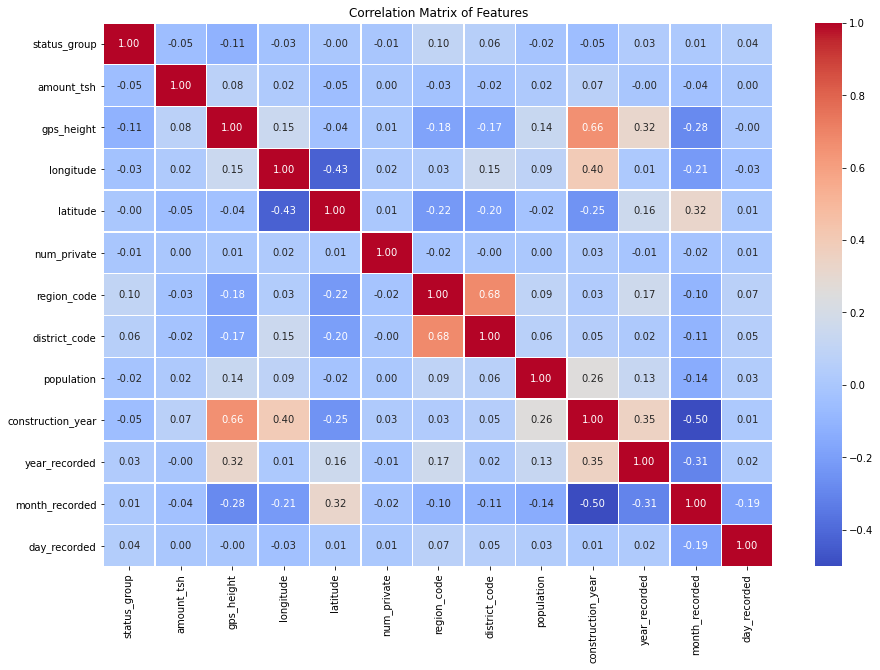

In [18]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix of Features')
plt.show()

While some columns border on being too correlated with each other (~0.80), none of columns exceed this threshold. If a column had multiple high correlations (either positive or negative) with other columns we would drop that column, but this is not the case. 

## Columns with too many unique values

Given the high amount of unique values that exist inside of various columns, we will bucket the values that fall under 1% of the columns total values. 

In [19]:
too_unique_columns = []

for col in wells_df.columns:
    if wells_df[col].dtype == 'object' and wells_df[col].nunique() > 20:
        too_unique_columns.append(col)
        
too_unique_columns

['funder',
 'installer',
 'wpt_name',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_name']

In [20]:
for col in too_unique_columns:
    if wells_df[col].dtype == 'object': 
        freq = wells_df[col].value_counts(normalize=True)
        mask = wells_df[col].isin(freq[freq >= 0.01].index)
        wells_df.loc[~mask, col] = 'other'

## Dropping Columns

In [21]:
are_identical = wells_df['quantity'].equals(wells_df['quantity_group'])
print('Are they identical?', are_identical)

Are they identical? True


We are going to drop the following columns:

- 'recorded_by'
    - All records were recorded by the same person. No unique data is provided.
- 'quantity_group'
    - This column is identical to 'quantity'
- 'subvillage'
    - When placed into the proportion based threshold cleaner above, no values had more than 1%. As such, all values were bucketed into the other category.
- 'ward'
    - When placed into the proportion based threshold cleaner above, no values had more than 1%. As such, all values were bucketed into the other category.

In [22]:
# Drop columns
wells_df.drop(['recorded_by', 'quantity_group', 'subvillage', 'ward'], axis=1, inplace=True)